In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import re
import matplotlib.pyplot as plt
import dgl
import itertools

from allennlp.modules.elmo import Elmo, batch_to_ids
from eunjeon import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score

plt.rc('font', family='Malgun Gothic')

c:\Users\User\anaconda3\envs\torch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data_dir = '../analysis_files/files/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, 'Wellness.csv'), encoding='cp949')
df = df[['유저', '챗봇', '감정_대분류', '상황키워드']]

In [5]:
df

,유저,챗봇,감정_대분류,상황키워드
0,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,분노,"대인관계(부부, 자녀)"
1,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?,분노,"대인관계(부부, 자녀)"
2,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.",분노,"대인관계(부부, 자녀)"
3,평소 다른 일을 할 때도 비슷해요. 생각한대로 안되면 화가 나고…그런 상황이 지속되...,화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.,분노,"직장, 업무 스트레스"
4,예전보다 화내는 게 과격해진 거 같아.,정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.,분노,"직장, 업무 스트레스"
...,...,...,...,...
1020,"그 사람이 응급실 의사한테 뭐라고 속닥거리니까, 저보고 갑자기 응급처치 끝났다고, ...",응급실이 있어서 다행이네요. 큰 문제는 없으신 거죠?,당황,건강
1021,파편이 튀어서 그 때 저도 응급실 가서 치료 받기도 했고…,응급실에 가셨다니 정말 놀랐어요. 아무 문제 없으신가요? 걱정 되네요.,당황,건강
1022,지금 상태가 너무 안 좋아서 학교 안 나가고 있어요.,상태가 더 안 좋아지셨군요. 걱정이 되네요.,불안,건강
1023,진짜 심해진 거 같긴 해요.,정말 힘드시겠어요. 지금도 증상이 심하신가요?,불안,건강


In [6]:
# 새로운 DataFrame 생성
new_rows = []
current_emotion = None
current_keyword = None
current_dialogue = []

for index, row in df.iterrows():
    if current_emotion == row['감정_대분류'] and current_keyword == row['상황키워드']:
        current_dialogue.extend([row['유저'], row['챗봇']])
    else:
        if current_emotion is not None:
            new_rows.append(current_dialogue + [current_emotion, current_keyword])
        current_emotion = row['감정_대분류']
        current_keyword = row['상황키워드']
        current_dialogue = [row['유저'], row['챗봇']]

# 마지막 대화 추가
if current_emotion is not None:
    new_rows.append(current_dialogue + [current_emotion, current_keyword])



In [7]:
def create_dataframe(data, num_columns):
    columns = [f'사람문장{i//2+1}' if i % 2 == 0 else f'시스템문장{i//2+1}' for i in range(num_columns - 2)] + ['감정_대분류', '상황키워드']
    new_df = pd.DataFrame([data], columns=columns)
    return new_df

In [8]:
# Create an empty list to store DataFrames
all_dataframes = []

for data in new_rows:
    if len(data) <= 4:
        new_df = create_dataframe(data, 4)
        all_dataframes.append(new_df)
    elif len(data) <= 6:
        new_df = create_dataframe(data, 6)
        all_dataframes.append(new_df)
    elif len(data) <= 8:
        new_df = create_dataframe(data, 8)
        all_dataframes.append(new_df)
    else:
        remaining_data = data[:]  # Create a copy of data

        while len(remaining_data) > 6:
            current_data = remaining_data[:6] + [remaining_data[-2]] + [remaining_data[-1]]
            new_df = create_dataframe(current_data, 8)
            all_dataframes.append(new_df)
            remaining_data = remaining_data[6:]

        if len(remaining_data) > 2:
            new_df = create_dataframe(remaining_data, len(remaining_data))
            all_dataframes.append(new_df)

# Concatenate all accumulated DataFrames
final_dataframe = pd.concat(all_dataframes, ignore_index=True)

In [9]:
# Save the final DataFrame to a CSV file
final_dataframe.to_csv(os.path.join(data_dir, 'Wellness_final_dataframe.csv'), encoding='cp949',index=False)

In [10]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, 'Wellness_final_dataframe.csv'), encoding='cp949')
df = df[['사람문장1', '시스템문장1', '사람문장2','시스템문장2','사람문장3','시스템문장3','감정_대분류', '상황키워드']]

In [11]:
# ELMo 모델 초기화
options_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json"
weight_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1)

# mecab 모델 다운로드
mecab = Mecab()

# elmo 모델 다운로드
elmo = elmo.to(device)

In [12]:
# 한국어 문장 형태소 분리 함수
def tokenize_korean_sentence(sentence):
    tokens = mecab.morphs(sentence)
    return tokens

In [13]:
def preprocessing(sentences) :
    sentences = re.sub(r'\([^)]*\)', '', sentences)
    sentences = sentences.replace('.', '')
    sentences = re.sub(r'[^가-힣\s]', '', sentences)
    sentences = re.sub(r'\b(?:cm|km|etc)\b', '', sentences)
    return sentences

In [14]:
def extract_sentence_features(sentence):
    # TF-IDF 벡터화 객체 생성
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")

    # 문장 길이
    sentence_length = len(sentence)

    # 품사 개수
    tokens = mecab.pos(sentence)
    pos_tags = [tag for _, tag in tokens]
    num_pos_tags = len(pos_tags)

    # 명사 추출
    nouns = mecab.nouns(sentence)

    # TF-IDF 벡터화 및 상위 3개 단어 추출
    top_words = ['', '', '']  # 단어가 없을 경우 빈 문자열로 초기화
    top_scores = [0.0, 0.0, 0.0]  # 단어가 없을 경우 TF-IDF 스코어를 0.0으로 초기화
    top_word_vectors = np.zeros((3,))  # 단어가 없을 경우 0 벡터로 초기화

    if nouns:
        tfidf_matrix = tfidf_vectorizer.fit_transform(nouns)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-3:][::-1]  # 상위 3개 단어의 인덱스 추출
        top_words = [feature_names[index] for index in top_indices]  # 상위 3개 단어 추출
        top_scores = [tfidf_scores[index] for index in top_indices]  # 상위 3개 단어의 TF-IDF 스코어 추출
        top_word_vectors = [tfidf_matrix.toarray()[0][index] for index in top_indices]  # 상위 3개 단어의 벡터값 추출

    return sentence_length, num_pos_tags, top_words, top_scores, top_word_vectors

In [15]:
data_train = []
data_test = []

# 레이블을 정수형으로 변환
label_mapping_emotion = {'기쁨': 0, '당황': 1, '분노': 2, '불안' : 3, '상처' : 4,'슬픔' : 5}  # 감정에 해당하는 레이블과 정수 매핑
label_mapping_situation = {'가족관계': 0, '건강': 1, '건강,죽음': 2, '대인관계' : 3, '대인관계(부부, 자녀)' : 4, '연애,결혼,출산' : 5, '재정' : 6, '재정,은퇴,노후준비' : 7, '직장, 업무 스트레스' : 8, '진로,취업,직장' : 9, '학교폭력/따돌림' : 10, '학업 및 진로' : 11}  # 상황에 해당하는 레이블과 정수 매핑

In [16]:
def calculate_and_add_similarity(G, i, source_node, target_node):
    prev_sentence_embedding = G.nodes[source_node]['feature']
    curr_sentence_embedding = G.nodes[target_node]['feature']

    # 코사인 유사도를 계산하기 위해 두 벡터를 같은 크기로 변경 (1차원으로 변환)
    prev_sentence_embedding = prev_sentence_embedding.view(-1)
    curr_sentence_embedding = curr_sentence_embedding.view(-1)

    # 코사인 유사도 계산
    similarity_score = F.cosine_similarity(prev_sentence_embedding, curr_sentence_embedding, dim=0)

    # 엣지 특성으로 추가
    G.edges[source_node, target_node]['sentence_similarity'] = similarity_score


In [17]:
# 문장의 최대 길이를 30으로 설정
max_sentence_length = 30

# 그래프 생성 및 노드 추가
graphs = []
for _, row in df.iterrows():
    G = nx.Graph()
    sentences = [row['사람문장1'], row['시스템문장1'], row['사람문장2'], row['시스템문장2'], row['사람문장3'], row['시스템문장3']]

    for i, sentence in enumerate(sentences):
        print(i, sentence)
        if pd.isna(sentence):  # NaN 값 처리
            sentence_embedding = torch.zeros(max_sentence_length, 1024).to(device)  # 0 벡터로 처리
        else:
            sentence = preprocessing(sentence)
            # 문장을 형태소로 분리
            tokens = tokenize_korean_sentence(sentence)
            # 문장을 ELMo 임베딩으로 변환
            character_ids = batch_to_ids([tokens]).to(device)  # GPU로 이동
            embeddings_output = elmo(character_ids)  # GPU로 이동
            sentence_embedding = torch.mean(embeddings_output["elmo_representations"][0], dim=0).to('cpu')
            # 문장 특징 추출
            sentence_length, num_pos_tags, top_words, top_scores, top_word_vectors = extract_sentence_features(sentence)

            # 변환된 특징 데이터를 텐서로 변환
            sentence_embedding_tensor = torch.tensor(sentence_embedding)

            # 문장의 길이를 확인하고 부족한 부분을 0 벡터로 패딩
            if sentence_embedding_tensor.size(0) < max_sentence_length:
                padding_size = max_sentence_length - sentence_embedding_tensor.size(0)
                padding_tensor = torch.zeros(padding_size, 1024)
                sentence_embedding_tensor = torch.cat([sentence_embedding_tensor, padding_tensor], dim=0)

            # 문장의 길이가 최대 길이를 초과하는 경우, 최대 길이까지만 남기고 잘라줌
            sentence_embedding_tensor = sentence_embedding_tensor[:max_sentence_length]

            length_tensor = torch.tensor(sentence_length)
            pos_tags_tensor = torch.tensor(num_pos_tags)
            top_word_vectors_tensor = torch.tensor(top_word_vectors)

        G.add_node(i)

        # 노드 특성 추가
        G.nodes[i]['feature'] = sentence_embedding_tensor
        G.nodes[i]['length'] = length_tensor
        G.nodes[i]['pos_tags'] = pos_tags_tensor
        G.nodes[i]['top_word_vectors'] = top_word_vectors_tensor

        if i > 0:
            # 엣지 정보 생성
            edge_index = i-1  # 엣지 번호
            G.add_edge(i-1, i, edge_index=edge_index)  # 엣지 정보는 인덱스로 설정

            # 엣지의 추가적인 특성 추가 (sentence_similarity, edge_type)
            calculate_and_add_similarity(G, i, i - 1, i)

            if i in [1, 3]:
                edge_type = 1 # 사람
                G.add_edge(i-1, i+1, edge_type=edge_type)

            elif i in [2, 4]:
                edge_type = 2 # 시스템
                G.add_edge(i-1, i+1, edge_type=edge_type)
                calculate_and_add_similarity(G, i, i - 2, i)
            else :
                continue

    # 감정 및 상황 레이블 할당
    y_emotion = label_mapping_emotion[row['감정_대분류']]
    y_situation = label_mapping_situation[row['상황키워드']]

    graphs.append((G, y_emotion, y_situation))

0 제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.


C:\Users\User\AppData\Local\Temp\ipykernel_5220\3946672534.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence_embedding_tensor = torch.tensor(sentence_embedding)


1 감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
similarity_score :  tensor(0.3121)
2 더 이상 내 감정을 내가 컨트롤 못 하겠어.
similarity_score :  tensor(0.3602)
similarity_score :  tensor(0.2741)
3 저도 그 기분 이해해요. 많이 힘드시죠?
similarity_score :  tensor(0.3851)
4 하루종일 오르락내리락 롤러코스터 타는 기분이에요.
similarity_score :  tensor(0.3701)
similarity_score :  tensor(0.3537)
5 그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.
similarity_score :  tensor(0.2488)
0 평소 다른 일을 할 때도 비슷해요. 생각한대로 안되면 화가 나고…그런 상황이 지속되면 폭발해버려요.
1 화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.
similarity_score :  tensor(0.3511)
2 예전보다 화내는 게 과격해진 거 같아.
similarity_score :  tensor(0.2207)
similarity_score :  tensor(0.2387)
3 정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.
similarity_score :  tensor(0.2827)
4 화가 안 참아져.
similarity_score :  tensor(0.2173)
similarity_score :  tensor(0.2608)
5 화가 너무 많이 날 때는 심호흡을 해보는 게 어떨까요? 씁- 후-
similarity_score :  tensor(0.2573)
0 나도 그런 거 아닌가 걱정돼.
1 걱정이 많으시군요. 걱정거리를 정리하는 시간을 가지면 도움이 되지 않을까요?  
similarity_score :  tensor(0.2460)
2 처음엔 치료 받으면 낫겠지 생각했는데, 낫지도 않고 계속 병

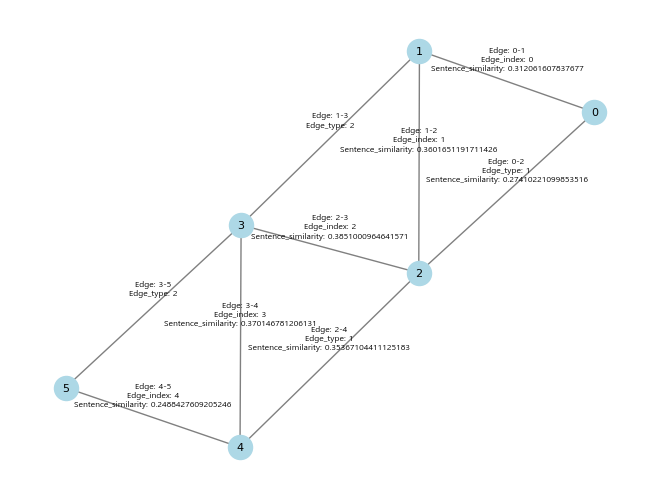

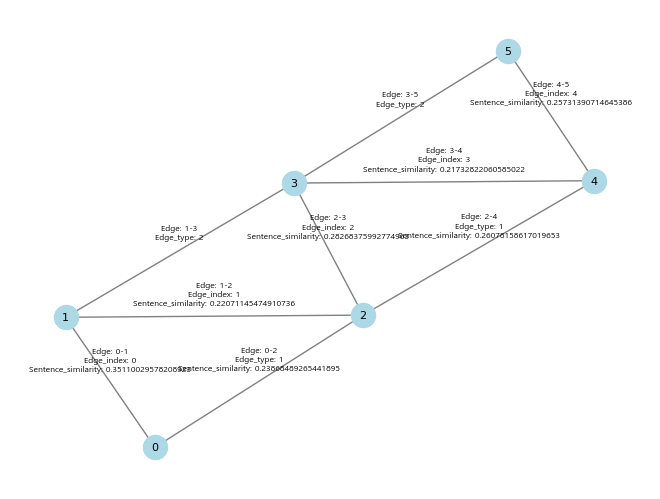

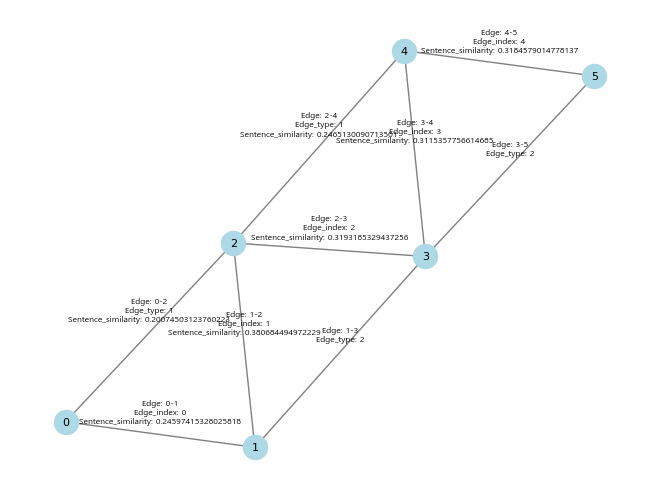

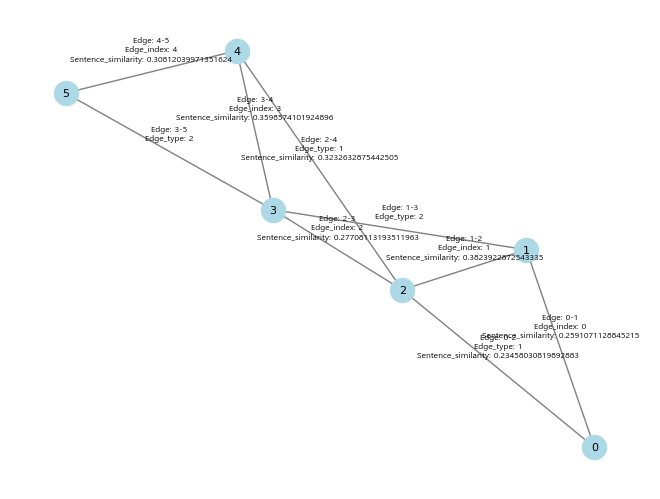

In [18]:
# 그래프 시각화
for i in range(4):  # 3개의 그래프만 표시
    graph, _, _ = graphs[i]  # graph, y_emotion, y_situation 중 graph만 사용
    pos = nx.spring_layout(graph)  # 그래프의 노드 위치 결정
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8)  # 그래프 그리기
    node_attributes = graph.nodes(data=True)  # 노드의 속성 정보 가져오기
    edge_attributes = graph.edges(data=True)  # 엣지의 속성 정보 가져오기


    # for node, attributes in node_attributes:
    #     x, y = pos[node]
    #     # 노드 속성 표시
    #     attribute_text = f"Node: {node}\n"
    #     for attr_name, attr_value in attributes.items():
    #         attribute_text += f"{attr_name.capitalize()}: {attr_value}\n"
    #     plt.text(x, y + 0.05, s=attribute_text, fontsize=6, ha='center', va='bottom')

    for edge in edge_attributes:
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        # 엣지 속성 표시
        attribute_text = f"Edge: {edge[0]}-{edge[1]}\n"
        for attr_name, attr_value in edge[2].items():
            attribute_text += f"{attr_name.capitalize()}: {attr_value}\n"
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, s=attribute_text, fontsize=6, ha='center', va='bottom')

    # y_emotion과 y_situation 레이블 표시
    # y_emotion = label_mapping_emotion[row['감정_대분류']]
    # y_situation = label_mapping_situation[row['상황키워드']]
    # plt.text(0, 1.1, s=f"y_emotion: {y_emotion}", fontsize=8, ha='center', va='bottom')
    # plt.text(0, 1.05, s=f"y_situation: {y_situation}", fontsize=8, ha='center', va='bottom')

    plt.show()

In [19]:
dgl_graphs = []
for (G, y_emotion, y_situation) in graphs:
    # Convert NetworkX graph to DGL graph
    dgl_G = dgl.DGLGraph(G)
    # 노드 및 엣지 속성을 graph.ndata 및 graph.edata에 저장
    num_nodes = len(G.nodes())
    num_edges = len(G.edges())
    dgl_G.ndata['feature'] = torch.zeros(num_nodes, 1024)
    dgl_G.ndata['length'] = torch.zeros(num_nodes , 1)
    dgl_G.ndata['pos_tags'] = torch.zeros(num_nodes, 1)
    dgl_G.ndata['top_word_vectors'] = torch.zeros(num_nodes, 3)  # top_word_vectors의 크기를 3으로 고정
    dgl_G.edata['edge_type'] = torch.zeros(num_edges * 2, 1)
    dgl_G.edata['sentence_similarity'] = torch.zeros(num_edges * 2, 1)

    for i in G.nodes():
        feature = G.nodes[i]['feature']
        if feature.shape != (1024,):
            # feature의 크기가 (1024,)가 아닌 경우, 1024 차원의 평균을 취하여 크기를 (1024,)로 축소
            feature = torch.mean(feature, dim=0)
        dgl_G.ndata['feature'][i] = feature
        dgl_G.ndata['length'][i] = G.nodes[i]['length']
        dgl_G.ndata['pos_tags'][i] = G.nodes[i]['pos_tags']
        top_word_vectors = G.nodes[i]['top_word_vectors']
        if top_word_vectors.shape != (3,):
            # top_word_vectors의 크기가 (3,)가 아닌 경우, 3 차원으로 크기를 고정하고 0으로 채워진 텐서로 변환
            top_word_vectors = torch.tensor(top_word_vectors)
            expanded_top_word_vectors = torch.zeros(3)
            expanded_top_word_vectors[:top_word_vectors.size(0)] = top_word_vectors
            top_word_vectors = expanded_top_word_vectors
        dgl_G.ndata['top_word_vectors'][i] = top_word_vectors

    for i, j in G.edges():
        if 'edge_type' in G.edges[i, j]:
            dgl_G.edata['edge_type'][j-1] = G.edges[i, j]['edge_type']
        else:
            dgl_G.edata['edge_type'][j-1] = 0

        if 'sentence_similarity' in G.edges[i, j]:
            dgl_G.edata['sentence_similarity'][j] = G.edges[i, j]['sentence_similarity']
        else:
            dgl_G.edata['sentence_similarity'][j] = 0

    dgl_G.ndata['y_emotion'] = torch.tensor([y_emotion] * num_nodes)
    dgl_G.ndata['y_situation'] = torch.tensor([y_situation] * num_nodes)

    dgl_graphs.append(dgl_G)

c:\Users\User\anaconda3\envs\torch\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
C:\Users\User\AppData\Local\Temp\ipykernel_5220\2794922956.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_word_vectors = torch.tensor(top_word_vectors)


In [20]:
for i in range(4):
    graph = dgl_graphs[i]
    print(f"Graph {i+1}:")
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Node features:")
    print(graph.ndata)
    print("Edge features:")
    print(graph.edata)
    print()

Graph 1:
Number of nodes: 6
Number of edges: 18
Node features:
{'feature': tensor([[-0.0335, -0.2995,  0.1018,  ...,  0.1473, -0.2309, -0.0508],
        [ 0.0912, -0.3334,  0.2032,  ...,  0.1101, -0.2245, -0.0146],
        [ 0.1083, -0.0664,  0.0965,  ...,  0.1310, -0.2050,  0.0250],
        [-0.0239, -0.0790,  0.1123,  ...,  0.1562, -0.1356, -0.0120],
        [ 0.0017, -0.0442,  0.0783,  ...,  0.1628, -0.0247, -0.0421],
        [ 0.0789, -0.2649,  0.1695,  ...,  0.2214, -0.1869, -0.0283]]), 'length': tensor([[45.],
        [30.],
        [23.],
        [20.],
        [26.],
        [37.]]), 'pos_tags': tensor([[24.],
        [16.],
        [12.],
        [11.],
        [ 9.],
        [22.]]), 'top_word_vectors': tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), 'y_emotion': tensor([2, 2, 2, 2, 2, 2]), 'y_situation': tensor([4, 4, 4, 4, 4, 4])}
Edge features:
{'edge_type': tensor([0., 0., 0., 0., 0., 0.

In [21]:
# 데이터 분할
train_graphs, test_graphs = train_test_split(dgl_graphs, test_size=0.2, random_state=42)

In [33]:
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = dgl.nn.SAGEConv(input_dim, hidden_dim, 'mean')  # SAGEConv를 사용하여 엣지 속성을 노드로 전파
        self.conv2 = dgl.nn.SAGEConv(hidden_dim, hidden_dim, 'mean')
        self.conv3 = dgl.nn.SAGEConv(hidden_dim, hidden_dim, 'mean')
        self.fc_emotion = nn.Linear(hidden_dim, output_dim['emotion'])
        self.fc_situation = nn.Linear(hidden_dim, output_dim['situation'])
        self.linear_transform = nn.Linear(1, hidden_dim)
        self.linear_transform2 = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, g):
        x = g.ndata['feature']
        length = g.ndata['length'].view(-1, 1)
        pos_tags = g.ndata['pos_tags'].view(-1, 1)
        top_word_vectors = g.ndata['top_word_vectors']
        sentence_similarity = g.edata['sentence_similarity']
        sentence_similarity = self.linear_transform(sentence_similarity)

        # 속성들을 모델에 입력으로 추가
        x = torch.cat([x, length, pos_tags, top_word_vectors], dim=1)
        x = self.conv1(g, x, edge_weight=sentence_similarity)  # SAGEConv에 sentence_similarity 엣지 속성 전달
        x = F.relu(x)
        x = self.conv2(g, x, edge_weight=sentence_similarity)  # SAGEConv에 sentence_similarity 엣지 속성 전달
        x = F.relu(x)
        x = self.conv3(g, x, edge_weight=sentence_similarity)  # SAGEConv에 sentence_similarity 엣지 속성 전달
        x = F.relu(x)

        sentence_similarity=sentence_similarity[:192]
        if sentence_similarity.shape == (192, 128) and x.shape == (192, 128):
            # 엣지 속성을 노드 속성과 함께 연결하여 모델의 입력으로 사용
            x = torch.cat([x, sentence_similarity], dim=1)
            x = self.linear_transform2(x)
            emotion_out = self.fc_emotion(x)
            situation_out = self.fc_situation(x)
        else :
            emotion_out = torch.zeros(192, 6)
            situation_out = torch.zeros(192, 12)

        return emotion_out, situation_out

In [34]:
# 학습 모델 초기화 및 손실 함수, 옵티마이저 설정
input_dim = 1029
hidden_dim = 128
learning_rate = 0.001
output_dim = {'emotion': len(label_mapping_emotion), 'situation': len(label_mapping_situation)}
model = GCNModel(input_dim, hidden_dim, output_dim)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
# 데이터 로더 생성
batch_size = 32
train_loader = GraphDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = GraphDataLoader(test_graphs, batch_size=batch_size, shuffle=True)


In [36]:
# 평가 함수 정의
def evaluate(model, dataloader):
    model.eval()
    y_true_emotion = []
    y_pred_emotion = []
    y_true_situation = []
    y_pred_situation = []

    with torch.no_grad():
        for batch in dataloader:
            g = batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']

            # Pad labels_emotion and labels_situation to size (192,) if they are smaller
            if labels_emotion.shape[0] < 192:
                padding_dim = 192 - labels_emotion.shape[0]
                labels_emotion = F.pad(labels_emotion, (0, padding_dim), value=0)
                labels_emotion = labels_emotion.clone().detach()  # Detach the tensor from the computation graph
            if labels_situation.shape[0] < 192:
                padding_dim = 192 - labels_situation.shape[0]
                labels_situation = F.pad(labels_situation, (0, padding_dim), value=0)
                labels_situation = labels_situation.clone().detach()  # Detach the tensor from the computation graph
            

            outputs_emotion, outputs_situation = model(g)
            _, predicted_emotion = torch.max(outputs_emotion, 1)
            _, predicted_situation = torch.max(outputs_situation, 1)
            y_true_emotion.extend(labels_emotion.tolist())
            y_pred_emotion.extend(predicted_emotion.tolist())
            y_true_situation.extend(labels_situation.tolist())
            y_pred_situation.extend(predicted_situation.tolist())

    accuracy_emotion = accuracy_score(y_true_emotion, y_pred_emotion)
    recall_emotion = recall_score(y_true_emotion, y_pred_emotion, average='macro')
    f1_emotion = f1_score(y_true_emotion, y_pred_emotion, average='macro')
    accuracy_situation = accuracy_score(y_true_situation, y_pred_situation)
    recall_situation = recall_score(y_true_situation, y_pred_situation, average='macro')
    f1_situation = f1_score(y_true_situation, y_pred_situation, average='macro')

    return accuracy_emotion, recall_emotion, f1_emotion, accuracy_situation, recall_situation, f1_situation



In [37]:
num_epochs = 70
train_acc_emotion_list = []
train_acc_situation_list = []
test_acc_emotion_list = []
test_acc_situation_list = []

for epoch in range(num_epochs):

    model.train()
    for batch in test_loader:
        g = batch
        labels_emotion = g.ndata['y_emotion']
        labels_situation = g.ndata['y_situation']

        # Pad labels_emotion and labels_situation to size (192,) if they are smaller
        if labels_emotion.shape[0] < 192:
            padding_dim = 192 - labels_emotion.shape[0]
            labels_emotion = F.pad(labels_emotion, (0, padding_dim), value=0)
            labels_emotion = labels_emotion.clone().detach()  # Detach the tensor from the computation graph
        if labels_situation.shape[0] < 192:
            padding_dim = 192 - labels_situation.shape[0]
            labels_situation = F.pad(labels_situation, (0, padding_dim), value=0)
            labels_situation = labels_situation.clone().detach()  # Detach the tensor from the computation graph

        
        optimizer.zero_grad()
        outputs_emotion, outputs_situation = model(g)
        loss_emotion = loss_function(outputs_emotion, labels_emotion)
        loss_situation = loss_function(outputs_situation, labels_situation)
        loss = loss_emotion + loss_situation
        if loss.requires_grad:  # loss를 계산할 필요가 있는 경우에만 backward를 수행
            loss.backward()
            optimizer.step()
        else:
            pass

    for batch in train_loader:
        g = batch
        labels_emotion = g.ndata['y_emotion']
        labels_situation = g.ndata['y_situation']

        # Pad labels_emotion and labels_situation to size (192,) if they are smaller
        if labels_emotion.shape[0] < 192:
            padding_dim = 192 - labels_emotion.shape[0]
            labels_emotion = F.pad(labels_emotion, (0, padding_dim), value=0)
            labels_emotion = labels_emotion.clone().detach()  # Detach the tensor from the computation graph
        if labels_situation.shape[0] < 192:
            padding_dim = 192 - labels_situation.shape[0]
            labels_situation = F.pad(labels_situation, (0, padding_dim), value=0)
            labels_situation = labels_situation.clone().detach()  # Detach the tensor from the computation graph


        optimizer.zero_grad()
        outputs_emotion, outputs_situation = model(g)
        loss_emotion = loss_function(outputs_emotion, labels_emotion)
        loss_situation = loss_function(outputs_situation, labels_situation)
        loss = loss_emotion + loss_situation
        if loss.requires_grad:  # loss를 계산할 필요가 있는 경우에만 backward를 수행
            loss.backward()
            optimizer.step()
        else:
            pass

    # 학습 데이터에 대한 평가
    train_accuracy_emotion, train_recall_emotion, train_f1_emotion, train_accuracy_situation, train_recall_situation, train_f1_situation = evaluate(model, train_loader)
    # 테스트 데이터에 대한 평가
    test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)

    # Append accuracy values to the lists
    train_acc_emotion_list.append(train_accuracy_emotion)
    train_acc_situation_list.append(train_accuracy_situation)
    test_acc_emotion_list.append(test_accuracy_emotion)
    test_acc_situation_list.append(test_accuracy_situation)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Emotion Accuracy: {train_accuracy_emotion:.4f} Recall: {train_recall_emotion:.4f} F1-score: {train_f1_emotion:.4f}")
    print(f"Train Situation Accuracy: {train_accuracy_situation:.4f} Recall: {train_recall_situation:.4f} F1-score: {train_f1_situation:.4f}")
    print(f"Test Emotion Accuracy: {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
    print(f"Test Situation Accuracy: {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
    print()


torch.Size([576])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x576 and 1024x128)

ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

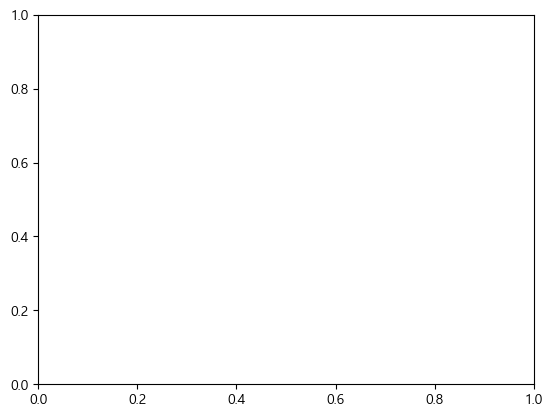

In [32]:
# Plotting the accuracy trend
epochs = range(1, num_epochs+1)

plt.plot(epochs, train_acc_emotion_list, label='Train Emotion Accuracy')
plt.plot(epochs, train_acc_situation_list, label='Train Situation Accuracy')
plt.plot(epochs, test_acc_emotion_list, label='Test Emotion Accuracy')
plt.plot(epochs, test_acc_situation_list, label='Test Situation Accuracy')

plt.title('Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()